In [32]:
import glob
from datetime import date

today = date.today().strftime("%Y%m%d")[2:]
print(f"Today: {today}")
# import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import sys, os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from scipy.integrate import simps

sns.set_theme(
    context="talk",
    palette="colorblind",
    style="ticks",
    rc={"axes.spines.right": False, "axes.spines.top": False},
)

Today: 251002


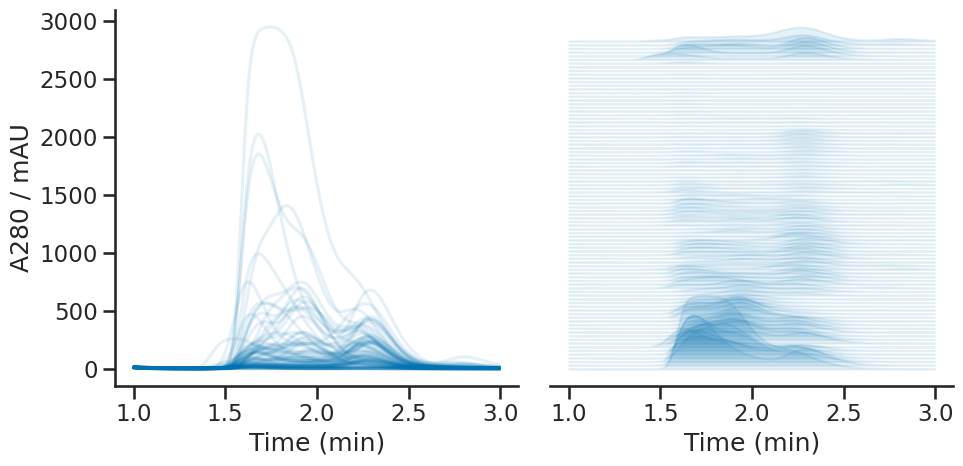

In [40]:
wl = '280'
ROI = [1.0, 3.0]  # Time range of interest
home_dir = "." #where you want figures to be saved
dfs = glob.glob(f'<path/to/your>/figures/figure5_more-allotypes/df_{wl}/*.csv')

# Prepare absorbance data for clustering
Abs_light = []
vol_light = []
for read_df in sorted(dfs, key=lambda x: (x.split('/')[-1][0], int(x.split('/')[-1].split('.')[0][1:]))):
    df = pd.read_csv(read_df)
    
    # Filter by time range (1-3 minutes)
    df = df[df['time'].between(ROI[0], ROI[1])]
    Abs_light.append(df['absorbance'].to_numpy())
    vol_light.append(df['time'].to_numpy())

# Ensure all arrays have the same length
max_length = max(len(a) for a in Abs_light)
Abs_light = np.array([np.pad(a, (0, max_length - len(a)), 'constant') for a in Abs_light])
vol_light = np.array([np.pad(v, (0, max_length - len(v)), 'constant', constant_values=np.nan) for v in vol_light])

# Perform hierarchical clustering
clustered_idx = hierarchy.dendrogram(
    hierarchy.linkage(Abs_light, method="average", optimal_ordering=True),
    no_plot=True,
)["leaves"]

# Determine vertical offset for stacked plot
delta = np.max(Abs_light) / 20

# Plotting
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

# Left plot: Overlay of all chromatograms
for vol, absb in zip(vol_light, Abs_light):
    ax[0].plot(vol, absb, color="C0", alpha=0.1)

# Remove top and right spines for the left plot
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set(xlabel="Time (min)", ylabel=f"A{wl} / mAU")

# Right plot: Stacked chromatograms
for i, idx in enumerate(clustered_idx):
    ax[1].fill_between(
        x=vol_light[idx],
        y1=Abs_light[idx] + i * delta,
        y2=i * delta,
        color="C0",
        alpha=0.1,
        zorder=i,
    )

# Remove top and right spines for the right plot
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set(xlabel="Time (min)", yticks=[])

# Title for both plots
#fig.suptitle(f"Clustered Chromatograms ($N = {len(dfs)}$)", fontsize=14)

# Final layout adjustments and display
plt.tight_layout()
plt.show()


In [41]:
# Debug: Check if Abs_light or vol_light arrays are empty
if Abs_light.size == 0 or vol_light.size == 0:
    raise ValueError("Abs_light or vol_light arrays are empty. Check data preparation.")
else:
    print(f"Abs_light and vol_light loaded successfully. Number of chromatograms: {len(Abs_light)}")

# Plotting: Only Left Plot
fig, ax = plt.subplots(figsize=(8, 5))  # Single plot

# Overlay of all chromatograms
for i, (vol, absb) in enumerate(zip(vol_light, Abs_light)):
    if len(vol) == 0 or len(absb) == 0:
        print(f"Skipping empty dataset at index {i}")
        continue
    if 76 <= (i + 1) <= 90:  # Samples 76-90
        ax.plot(vol, absb, color="C1", alpha=0.3, label="unmutated" if i == 75 else None)  # Orange
    else:
        ax.plot(vol, absb, color="C0", alpha=0.4)  # Blue

# Add vertical dotted lines to the plot
ax.axvline(1.69, color="gray", linestyle="--", linewidth=1, label="expected monomer range")
ax.axvline(2.01, color="gray", linestyle="--", linewidth=1)
print("Added vertical lines to the plot.")

# Customize plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel="Time (min)", ylabel=f"A{wl} / mAU")
ax.legend(loc="upper right", fontsize=10, frameon=False)

# Save the figure as PNG
output_path = f"{home_dir}/overlay_chromatograms.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")  # Save the plot with high resolution
plt.close(fig)  # Ensure the figure is properly closed after saving

print(f"Plot saved as {output_path}")


Abs_light and vol_light loaded successfully. Number of chromatograms: 90
Added vertical lines to the plot.
Plot saved as /home/lgue26/wet_lab/hplc/20241025/overlay_chromatograms.png


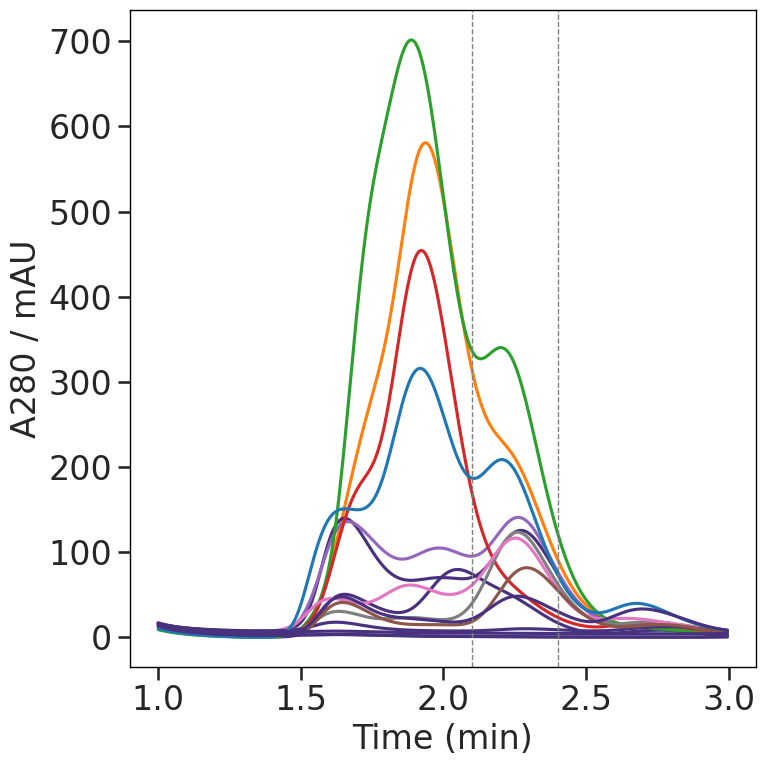

In [42]:
import matplotlib.pyplot as plt

def plot_chromatograms(vol_light, Abs_light, wl):
    fig, ax = plt.subplots(figsize=(8, 8))  # Set figure size to 8x8

    # Label assignments matching scatterplot
    labels = {
        86: 'E*01:03',
        76: 'A*01:01',
        80: 'A*03:01',
        81: 'A*24:02',
        79: 'A*02:01',
        85: 'B*58:01',
        83: 'B*08:01',
        82: 'B*07:02'
    }

    # Get color palette
    color_palette = plt.get_cmap('tab10').colors
    label_colors = {key: color_palette[i] for i, key in enumerate(labels.keys())}
    for i, (vol, absb) in enumerate(zip(vol_light, Abs_light)):
        sample_num = i + 1
        if 76 <= sample_num <= 90:
            if sample_num in labels:
                ax.plot(vol, absb, color=label_colors[sample_num])
            else:
                ax.plot(vol, absb, color="#48327F")  # Default purple for unlabeled

    # Add vertical lines for expected monomer range
    ax.axvline(2.1, color="gray", linestyle="--", linewidth=1, label="expected monomer\nrange")
    ax.axvline(2.4, color="gray", linestyle="--", linewidth=1)

    # Borders (spines)
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # Labels, ticks
    ax.set_xlabel("Time (min)", fontsize=24)
    ax.set_ylabel(f"A{wl} / mAU", fontsize=24)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)


    plt.tight_layout()
    plt.savefig("5a_updated.png", dpi=400)
    plt.show()
plot_chromatograms(vol_light, Abs_light, wl)


Filtered files: ['/home/lgue26/wet_lab/hplc/20241025/df_280/88.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/81.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/86.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/90.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/87.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/80.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/89.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/76.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/78.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/83.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/84.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/79.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/77.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/85.csv', '/home/lgue26/wet_lab/hplc/20241025/df_280/82.csv']

Data Points:
76.csv: Monomer Fraction = 0.2215, Total AUC = 268.57
77.csv: Monomer Fraction = 0.2796, Total AUC = 48.66
78.csv: Monomer Fraction = 0.2973, Total AUC = 100.84
79.csv: Monomer Fraction = 0

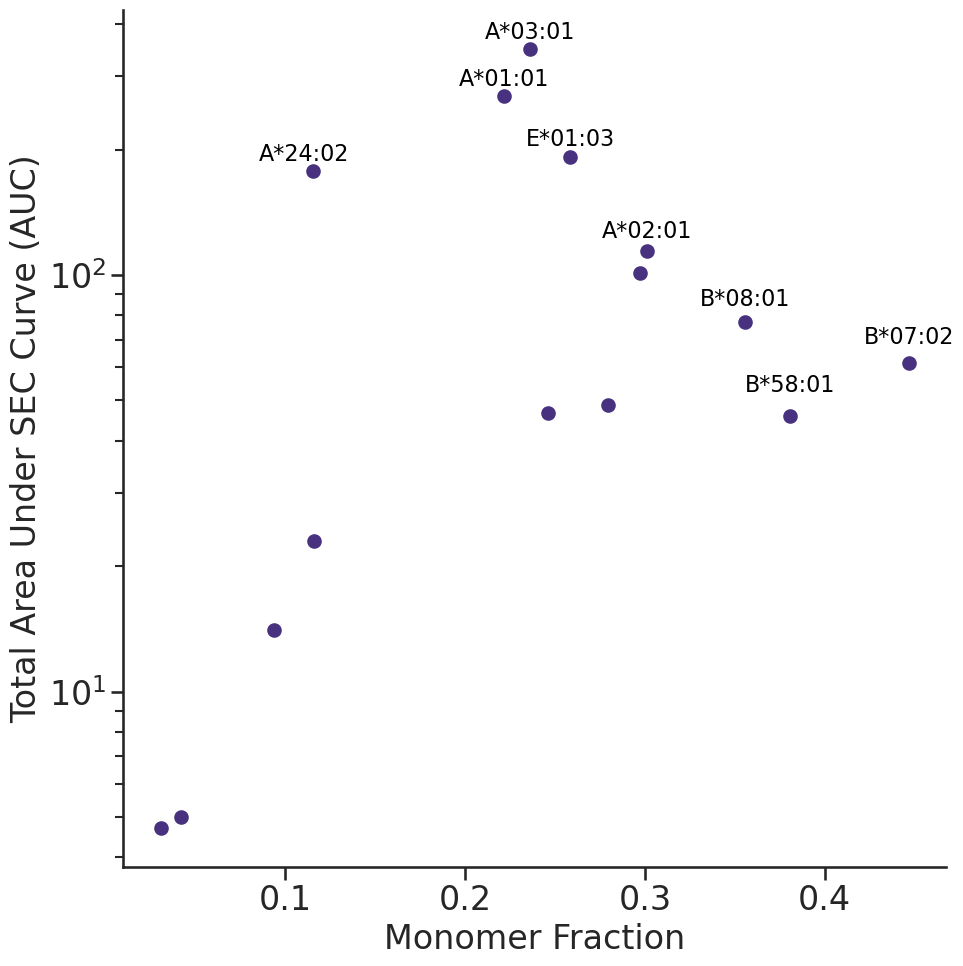

In [56]:
# Settings
wl = '280'
ROI = [1.0, 3.5]  # Retention volume range for total AUC calculation
monomer_range = [2.1, 2.4]  # Retention volume range for monomer peak

# Filter for CSV files numbered 76 to 94
selected_dfs = [
    df for df in dfs
    if df.split('/')[-1].split('.')[0] in [f"{i}" for i in range(76, 95)]
]

print(f"Filtered files: {selected_dfs}")  # Debugging: Check filtered file list

# Initialize lists to store data
total_aucs = []
monomer_fractions = []
filenames = []  # To track filenames corresponding to data points

# Process each chromatogram
for read_df in sorted(selected_dfs, key=lambda x: int(x.split('/')[-1].split('.')[0])):
    try:
        df = pd.read_csv(read_df)
        
        # Check for required columns
        if 'time' not in df.columns or 'absorbance' not in df.columns:
            print(f"Skipping {read_df}: Required columns not found.")
            continue
        
        # Filter by retention volume range (1.0–3.5 min)
        df = df[df['time'].between(ROI[0], ROI[1])]
        if df.empty:
            print(f"Skipping {read_df}: No data in ROI.")
            continue
        
        # Total AUC for time = 1.0–3.5 min
        total_auc = simps(df['absorbance'], df['time'])
        
        # Filter data further for monomer peak range (1.7–2.0 min)
        monomer_df = df[df['time'].between(monomer_range[0], monomer_range[1])]
        monomer_auc = simps(monomer_df['absorbance'], monomer_df['time']) if not monomer_df.empty else 0
        
        # Monomer fraction: Use total AUC and monomer AUC
        monomer_fraction = monomer_auc / total_auc if total_auc > 0 else 0
        
        # Store the total AUC, monomer fraction, and filename
        total_aucs.append(total_auc)
        monomer_fractions.append(monomer_fraction)
        filenames.append(read_df.split('/')[-1])
    except Exception as e:
        print(f"Error processing {read_df}: {e}")

# Print data points and their corresponding filenames
print("\nData Points:")
for filename, monomer_fraction, total_auc in zip(filenames, monomer_fractions, total_aucs):
    print(f"{filename}: Monomer Fraction = {monomer_fraction:.4f}, Total AUC = {total_auc:.2f}")

# Scatterplot visualization
plt.figure(figsize=(10,10))

for filename, x, y in zip(filenames, monomer_fractions, total_aucs):
    if filename == "86.csv":
        plt.scatter(x, y, color="#48327F", label="expresses well" if filename == "86.csv" else None)
        plt.text(x, y + 7, 'E*01:03', fontsize=16, ha='center', va='bottom', color='black') 
    elif filename == "76.csv":
        plt.scatter(x, y, color="#48327F", label=None)
        plt.text(x, y + 8, 'A*01:01', fontsize=16, ha='center', va='bottom', color='black')
    elif filename == "80.csv":
        plt.scatter(x, y, color="#48327F", label="expresses well, mostly monomeric" if filename == "80.csv" else None)
        plt.text(x, y + 10, 'A*03:01', fontsize=16, ha='center', va='bottom', color='black')  
    elif filename == "81.csv":
        plt.scatter(x, y, color="#48327F", label=None)
        plt.text(x -0.005, y + 5, 'A*24:02', fontsize=16, ha='center', va='bottom', color='black')  
    elif filename == "79.csv":
        plt.scatter(x, y, color="#48327F", label=None)
        plt.text(x, y + 5, 'A*02:01', fontsize=16, ha='center', va='bottom', color='black')  
    elif filename == "85.csv":
        plt.scatter(x, y, color="#48327F", label=None)
        plt.text(x, y + 5, 'B*58:01', fontsize=16, ha='center', va='bottom', color='black')  
    elif filename == "83.csv":
        plt.scatter(x, y, color="#48327F", label=None)
        plt.text(x, y + 5, 'B*08:01', fontsize=16, ha='center', va='bottom', color='black') 
    elif filename == "82.csv":
        plt.scatter(x, y, color="#48327F", label=None)
        plt.text(x, y + 5, 'B*07:02', fontsize=16, ha='center', va='bottom', color='black')  
    else:
        plt.scatter(x, y, color="#48327F")

plt.xlabel('Monomer Fraction', fontsize=24)
plt.ylabel('Total Area Under SEC Curve (AUC)', fontsize=24)
plt.yscale('log')  # Apply log scale to the y-axis
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=10, loc="lower right", frameon=False)  # Updated legend

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
plt.tight_layout()

output_path = f"{home_dir}/scatterplot.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

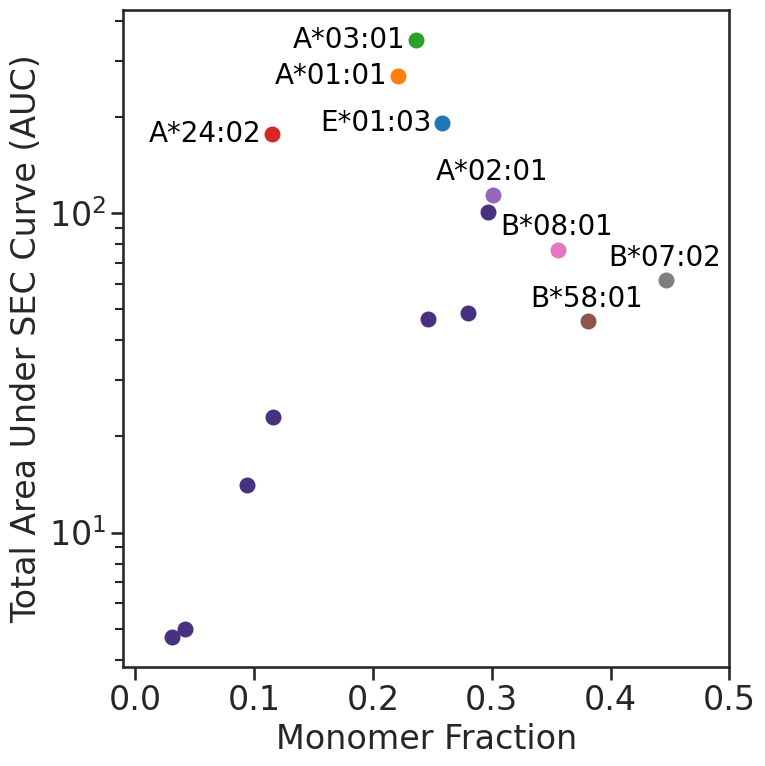

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
default_color = "#48327F"
color_palette = plt.get_cmap('tab10').colors

# Assign colors to labels
labels = {
    "86.csv": 'E*01:03',
    "76.csv": 'A*01:01',
    "80.csv": 'A*03:01',
    "81.csv": 'A*24:02',
    "79.csv": 'A*02:01',
    "85.csv": 'B*58:01',
    "83.csv": 'B*08:01',
    "82.csv": 'B*07:02'
}
label_colors = {key: color_palette[i] for i, key in enumerate(labels.keys())}

# Labels that should go *above* the points
above_labels = {'A*02:01', 'B*08:01', 'B*07:02', 'B*58:01'}

# Plot points
for filename, x, y in zip(filenames, monomer_fractions, total_aucs):
    if filename in labels:
        ax.scatter(x, y, color=label_colors[filename], s=100)  # Thicker points

        allele = labels[filename]

        # Default offsets
        x_offset = -0.009
        y_offset = 0
        va = 'center'

        # Adjust label position for specified alleles
        if allele in above_labels:
            x_offset = -0.001
            y_offset = 0.06 * y  # Slight vertical offset above
            va = 'bottom'

        ax.text(
            x + x_offset, y + y_offset,
            allele,
            fontsize=20,
            ha='center' if allele in above_labels else 'right',
            va=va,
            color='black'
        )
    else:
        ax.scatter(x, y, color=default_color, s=100) 

ax.set_xlim(-.01, 0.5)
ax.set_xlabel('Monomer Fraction', fontsize=24)
ax.set_ylabel('Total Area Under SEC Curve (AUC)', fontsize=24)
ax.set_yscale('log')
ax.tick_params(labelsize=24)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.tight_layout()
output_path = f"{home_dir}/5b_updated_v2.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()